In [52]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.ndimage.filters
%matplotlib inline

In [26]:
filename = '/Users/forero/Illustris_data/CIC_256_DM_TNG300-3.hdf5'
f = h5py.File(filename, 'r')
print(f.keys())
data = f['density'][:,:,:]
data = (data - np.mean(data))/np.mean(data)
print(np.shape(data))
f.close()

filename = '/Users/forero/Illustris_data/TSC_512_DM_TNG300-3.hdf5'
f = h5py.File(filename, 'r')
print(f.keys())
data_old = f['density'][:,:,:]
print(np.shape(data_old))
f.close()

<KeysViewHDF5 ['density']>
(256, 256, 256)
<KeysViewHDF5 ['density']>
(512, 512, 512)


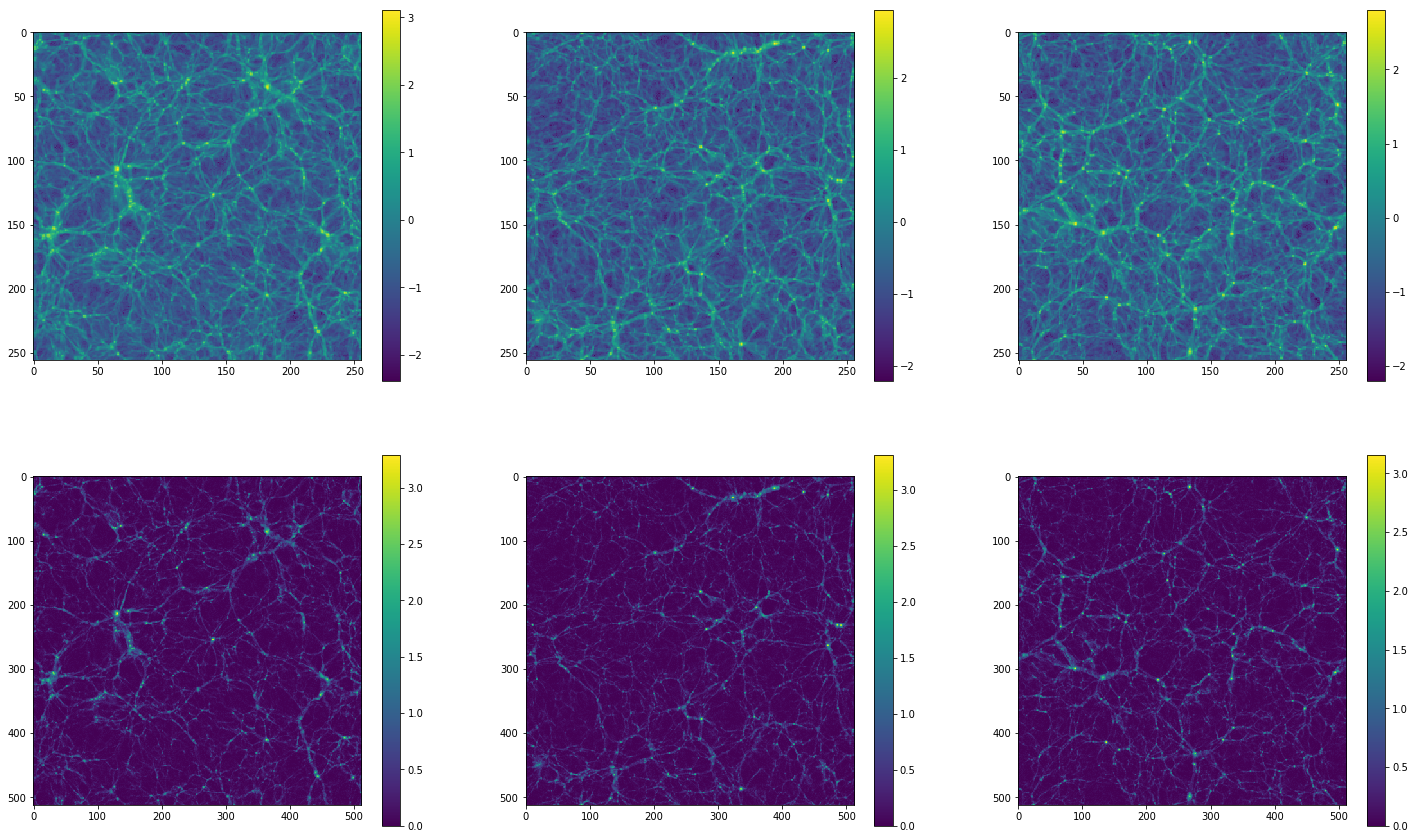

In [27]:
plt.figure(figsize=(25,15))

plt.subplot(2,3,1)
plt.imshow(np.log10(data[:,100,:]+1))
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(np.log10(data[20,:,:]+1))
plt.colorbar()

plt.subplot(2,3,3)
plt.imshow(np.log10(data[:,:,30]+1))
plt.colorbar()



plt.subplot(2,3,4)
plt.imshow(np.log10(data_old[:,200,:]+1))
plt.colorbar()

plt.subplot(2,3,5)
plt.imshow(np.log10(data_old[40,:,:]+1))
plt.colorbar()


plt.subplot(2,3,6)
plt.imshow(np.log10(data_old[:,:,60]+1))
plt.colorbar()

In [42]:
fft_lowres = np.fft.fftn(data)
fft_lowres[0,0,0]=0.0
back_data = np.fft.ifftn(fft_lowres)

In [43]:
n_side = np.shape(fft_lowres)[0]
print(n_side)

L_box = 205.0 # in Mpc/h
delta = L_box/n_side
k_2_values = np.ones((n_side, n_side, n_side))
for i in range(n_side):
    for j in range(n_side):
        for k in range(n_side):
            k_i = i
            k_j = j
            k_k = k
            if i > n_side/2:
                k_i = n_side - i
            if j > n_side/2:
                k_j = n_side - j
            if k > n_side/2:
                k_k = n_side - k
            
            k_2_values[i, j, k] = -(2.0*np.pi*k_i/L_box)**2 + -(2.0*np.pi*k_j/L_box)**2 + -(2.0*np.pi*k_k/L_box)**2
k_2_values[0, 0, 0] = 1.0

256


In [160]:
fft_potential = fft_lowres/k_2_values
potential = np.fft.ifftn(fft_potential)

density = scipy.ndimage.filters.laplace(np.real(potential), mode='wrap')/(delta**2)
#r = data/density
#potential = potential * r
#density = scipy.ndimage.filters.laplace(np.real(potential), mode='wrap')/(delta**2)
#print(np.median(data), np.median(density))
#factor = np.median(data)/np.median(density)
#print(np.min(density)*factor)

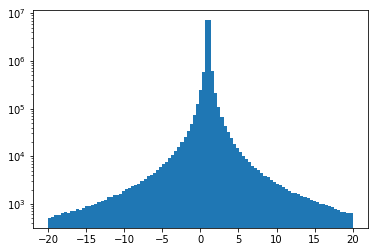

In [161]:
r = data/density
_=plt.hist(r.flatten(), bins=np.linspace(-20,20,100), log=True)

/Users/forero/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


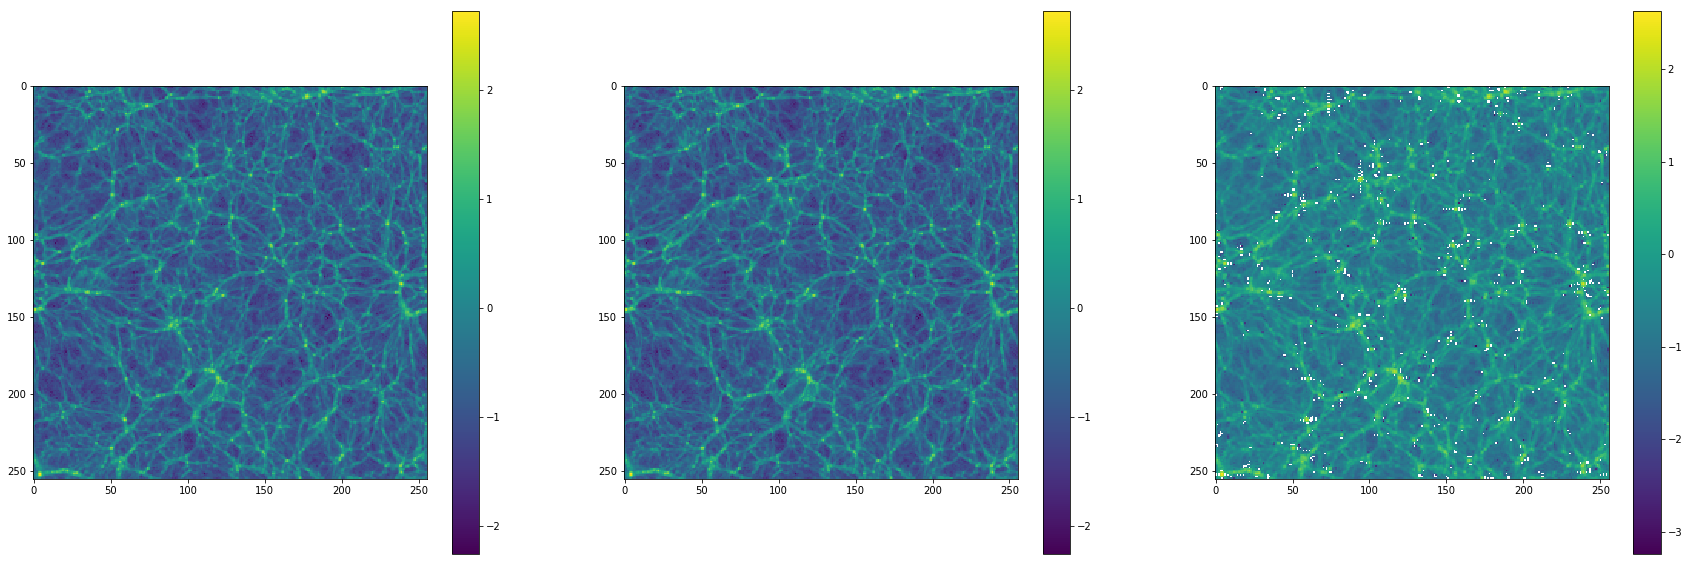

In [162]:
plt.figure(figsize=(30,10))

plt.subplot(1,3,1)
plt.imshow(np.log10(np.real(back_data[10,:,:] + 1)))
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.log10(np.real(data[10,:,:] + 1)))
plt.colorbar()

density[density<-1.0]=-1.0 
plt.subplot(1,3,3)
plt.imshow(np.log10(density[10,:,:] + 1.00))
plt.colorbar()

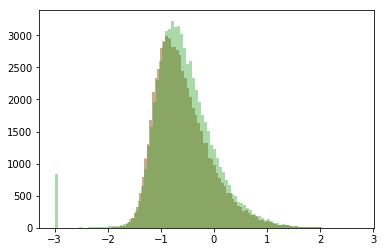

In [123]:
slice_id = 10
_ = plt.hist(np.log10(np.real(back_data[slice_id,:,:].flatten() + 1)), bins=100, alpha=0.4)
_ = plt.hist(np.log10(np.real(data[slice_id,:,:].flatten() + 1)), bins=100, alpha=0.4)
r = density[slice_id,:,:].flatten()
r[r<-1.0] = -1.0
_ = plt.hist(np.log10(r + 1.001), bins=100, alpha=0.4)

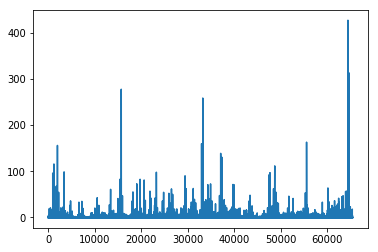

In [124]:
plt.plot(r)

/Users/forero/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10


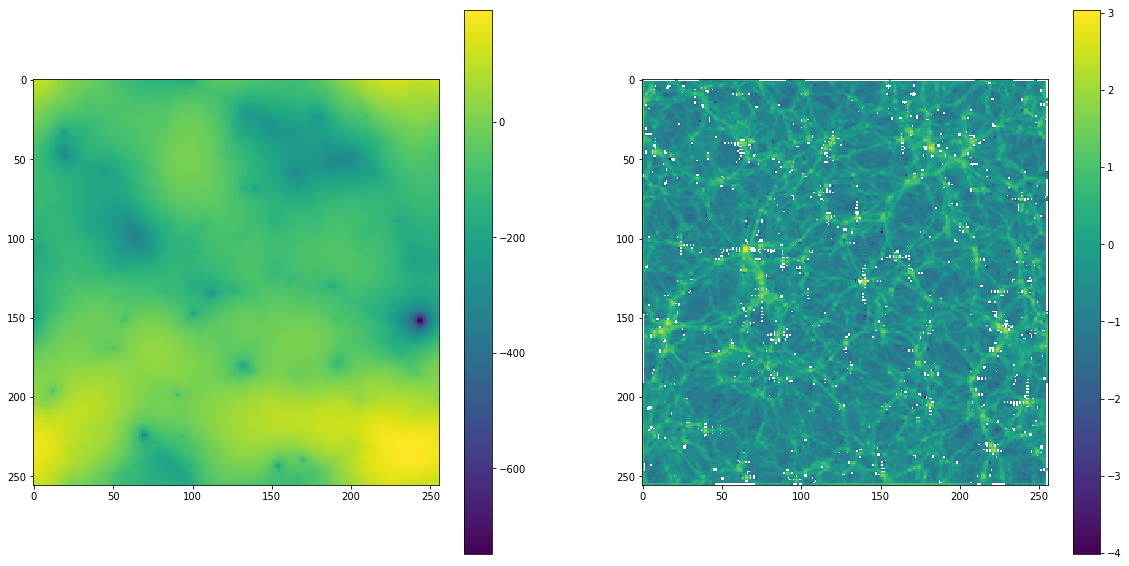

In [57]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(np.real(potential[100,:,:]))
plt.colorbar()

dens = potential[100,:,:].copy()

plt.subplot(1,2,2)
plt.imshow(np.log10(np.real(density[:,100,:])+1.0))
plt.colorbar()
